In oure last notebook( [Part2_Simple_Models_In_Plant_Classification](https://github.com/Mohammad-Amirifard/Plant-Classification-Polimi/blob/main/Part2_Simple_Models_In_Plant_Classification.ipynb)), we used simple models to calssify plants, but they were not really successful. So, here we use more advanced models, using transfer learnings and do fine tuning on them.
Note: our dataset  is clean here, without outliers and duplicates.  [Link to downlaod clean dataset](https://drive.google.com/drive/folders/1CzLGEZA7S0WhyVMTMUM-j4J6ptd6WyOx?usp=drive_link)

### 1-Mount Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive') # mount google drive to /content directory

Mounted at /content/drive


####1-1 copy clea dataset to /content direcory

In [2]:
# Here, /content/drive/MyDrive/Projects/Plant Classification Polimi/Dataset/clean_plant_dataset.npz is the address of clean data in my drive. You must replace it with yours.
!cp  "/content/drive/MyDrive/Projects/Plant Classification Polimi/Dataset/clean_plant_dataset.npz" "/content"

### 2-Import Libraries

In [3]:
import os, warnings,logging,cv2, keras
from skimage.color import rgb2lab, deltaE_cie76
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras import callbacks
from tensorflow.keras.utils import to_categorical
from keras import models, layers
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### 3-Fix randomness and hide warnings

In [4]:
seed = 42
#####
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'
#####
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

### 4-Set first parameters of tensorflow

In [5]:
# Import tensorflow
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print("tensorflow_version",tf.__version__)

tensorflow_version 2.14.0


### 5-Load dataset

In [6]:
dataset = np.load("/content/clean_plant_dataset.npz", allow_pickle=True)

In [7]:
keys = list(dataset.keys())
print('keys in our dataset are: ', keys)
print('*'*100)

keys in our dataset are:  ['clean_x', 'clean_y']
****************************************************************************************************


In [8]:
# Watch keys available in the numpy array
keys = list(dataset.keys())
print('keys in our dataset are: ', keys)
print('*'*100)

# look at data shape
data = dataset["clean_x"]
no_images = data.shape[0]
size_images = data.shape[1:3]
print('Data shape: ',data.shape)
print('*'*100)

# Lool aat labels
labels = dataset["clean_y"]
no_labels = labels.shape[0]
print("Labels are : ",labels)
print('*'*100)

# Look at bing balanced or imbalanced
_, counts = np.unique(labels,return_counts=True) # count occurrence of each item
no_healthy_images = counts[0]
no_unhealthy_images = counts[1]

# pass variables to a dictionary to be used as dataframe for a better show
info_table_dict = {"no_images":no_images, "image_width": size_images[0],"image_length": size_images[1], "no_labels":no_labels,
                   "no_healthy_images":no_healthy_images,"percentage%":no_healthy_images*100/no_labels,
                   "no_unhealthy_images":no_unhealthy_images,"percentage %":no_unhealthy_images*100/no_labels }
info_table = pd.DataFrame(info_table_dict, index =['value'])
info_table

keys in our dataset are:  ['clean_x', 'clean_y']
****************************************************************************************************
Data shape:  (4850, 96, 96, 3)
****************************************************************************************************
Labels are :  [0 0 0 ... 0 0 0]
****************************************************************************************************


,no_images,image_width,image_length,no_labels,no_healthy_images,percentage%,no_unhealthy_images,percentage %
value,4850,96,96,4850,3060,63.092784,1790,36.907216


### 6-Split data into training, valdiation and testing blocks

In [9]:
# Split the dataset into training and test sets
x_train_data, x_test, y_train_data, y_test = train_test_split(
    data,
    labels,
    test_size = 100,
    shuffle =True,
    random_state=seed,
    stratify=labels
)

In [10]:
# Further split the combined training and validation set into a training set and a validation set
x_train, x_val, y_train, y_val = train_test_split(
    x_train_data,
    y_train_data,
    test_size = len(x_test), # Ensure validation set size matches test set size--> Why??
    random_state=seed,
    shuffle =True,
    stratify=y_train_data
)

In [11]:
# Print the shapes of different datsets after splitting the main dataset into training, validation, testing parts
print('X_train.shape:',x_train.shape,'y_train.shape:', y_train.shape)
print('X_val.shape:',x_val.shape, 'y_val.shape:',y_val.shape)
print('X_test.shape:',x_test.shape,'y_test.shape', y_test.shape)

X_train.shape: (4650, 96, 96, 3) y_train.shape: (4650,)
X_val.shape: (100, 96, 96, 3) y_val.shape: (100,)
X_test.shape: (100, 96, 96, 3) y_test.shape (100,)


### 7-Watch data distribution in three blocks

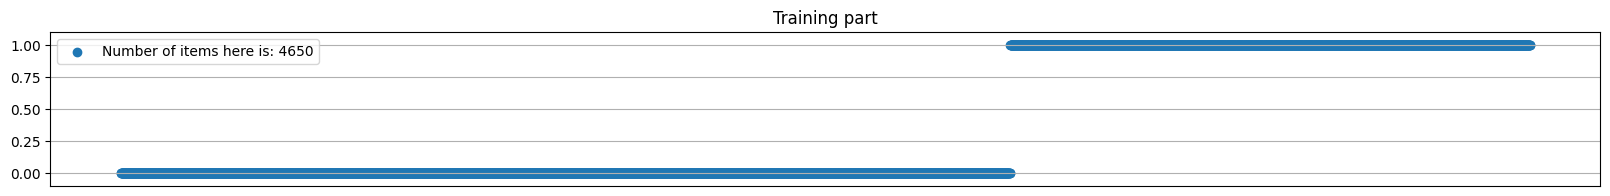

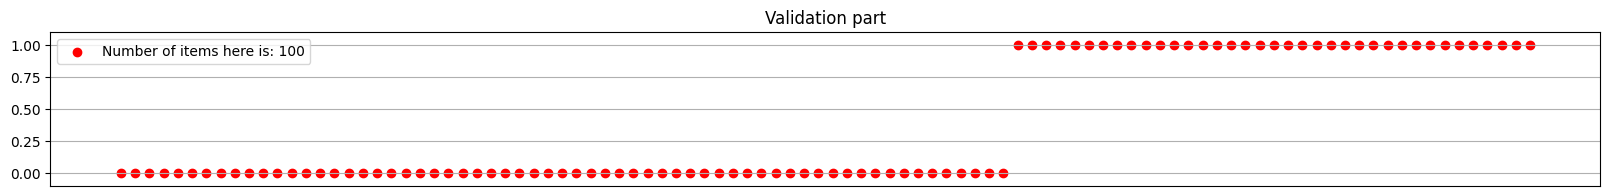

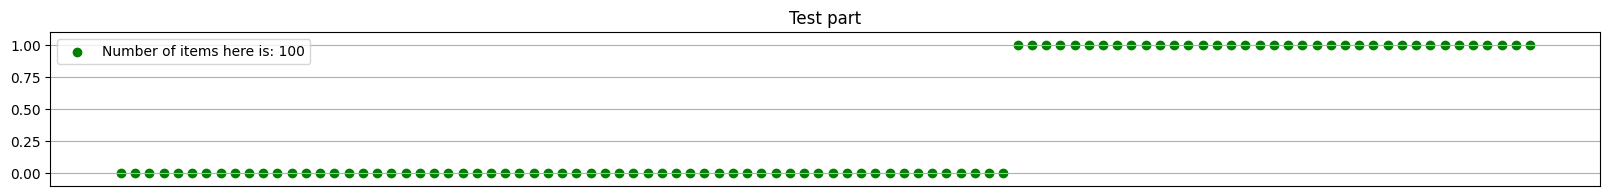

In [12]:
# Create three separate subplots to visualize the sorted target variable values for the training, validation, and test sets

# Create a figure for the training labels subplot
plt.figure(figsize=(20, 2))
plt.scatter((np.arange(y_train.shape[0])), np.sort(y_train, axis=0), label=f'Number of items here is: {y_train.shape[0]}')
plt.title('Training part')
plt.xticks([])  # Remove x-axis ticks
plt.grid(0.2)   # Add a grid with opacity 0.2 for reference
plt.ylim([-0.1, 1.1])  # Set the y-axis limits to [0.1, 1.1]
plt.legend()

# Create a figure for the validation labels subplot
plt.figure(figsize=(20, 2))
plt.scatter(np.arange(y_val.shape[0]), np.sort(y_val, axis=0),color='red',label=f'Number of items here is: {y_val.shape[0]}')
plt.title('Validation part')
plt.xticks([])  # Remove x-axis ticks
plt.grid(0.2)   # Add a grid with opacity 0.2 for reference
plt.ylim([-0.1, 1.1])  # Set the y-axis limits to [0.1, 1.1]
plt.legend()

# Create a figure for the test labels subplot
plt.figure(figsize=(20, 2))
plt.scatter(np.arange(y_test.shape[0]), np.sort(y_test, axis=0),color='green', label=f'Number of items here is: {y_test.shape[0]}')
plt.title('Test part')
plt.xticks([])  # Remove x-axis ticks
plt.grid(0.2)   # Add a grid with opacity 0.2 for reference
plt.ylim([-0.1, 1.1])  # Set the y-axis limits to [0.1, 1.1]
plt.legend()

# Display the plots
plt.show()

### 9-Callbacks

In [13]:
def Checkpoint(address):

  # CheckPoint callback ---> to save wieghts
  checkpoint_path = address # The path to save wights of the model after training
  My_ModelCheckpoint_callback =callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                          monitor='val_accuracy',
                                          verbose=1,
                                          save_weights_only=False,
                                          save_best_only=True,
                                          mode='max',
                                          save_freq ='epoch')
  return My_ModelCheckpoint_callback

##############################################################################
def earlystopping():

  # EarlyStopping callback --> Stop learning if it does not see any imporvement.
  My_EarlyStopping_callback = callbacks.EarlyStopping(monitor="val_accuracy",
                                                  min_delta=.02,
                                                  patience=25,
                                                  verbose=1,
                                                  mode="max",
                                                  restore_best_weights=True)
  return My_EarlyStopping_callback

##############################################################################
def learning_rate_reduction():
  learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                              patience = 5, verbose=1,
                                              factor=0.2, min_lr=1e-5)
  return learning_rate_reduction

### 10-Plot accuracy

In [14]:
def plot_accuracy(history_dict):
  plt.figure(figsize=(21, 4))
  accuracy_colors = ['#a1c9f4', '#ffc58a', '#9ae6a0', '#f6a1a1', '#c3b9d0',
                  '#bf9a8a', '#f1c7e6', '#c0c0c0', '#e3e0a7', '#8edbf0']

  val_accuracy_colors = ['#0e5a8d', '#c1680a', '#1d6c1d', '#861b1b', '#594173',
                 '#513c34', '#a85894', '#595959', '#7f7d12', '#0e688c']
  index = 0
  for name in history_dict.keys():
      plt.plot(history_dict[name]['accuracy'], label=f"{name}_accuracy", alpha=0.8,color=accuracy_colors[index])
      plt.plot(history_dict[name]['val_accuracy'], label=f"{name}_val_accuracy", alpha=0.8,color=val_accuracy_colors[index])
      index+=1

  plt.title("Graphs")
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Validation Accuracy')
  plt.grid(alpha=0.3)
  plt.show()

# Example usage:
# history_dict = {'model1': {'val_accuracy': [0.5, 0.6, 0.7, 0.8]},
#                 'model2': {'val_accuracy': [0.4, 0.5, 0.6, 0.7]}}
# plot_accuracy(history_dict)


In [15]:
history_dict ={} # to save history of different models

### 11- Trun labels to categories

In [16]:
# since we use softamx in our models, we turn y to categorical class
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [17]:
print("y_train.shape: ",y_train.shape)
print("5 items of y_train in this state:\n ",y_train[:5])

y_train.shape:  (4650, 2)
5 items of y_train in this state:
  [[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


###12-Hyperparameters

In [18]:
# Define the input shape for the neural network, excluding the batch size
input_shape = x_train.shape[1:]
print('input_shape',input_shape)

# Define the batch size for training
batch_size = 64

# Define the number of training epochs and learning_rate
epochs = 100
learning_rate = 1e-3


input_shape (96, 96, 3)


###12- ImageGenreator

In [19]:
# Create the ImageDataGenerator for training data
train_datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect',
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input #################### Be careful about Feature Scaling of your model.#####################################################
)

# Generate the training data
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)

In [20]:
# Create the ImageDataGenerator for validation data
val_datagen = ImageDataGenerator(
preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input#################### Be careful about Feature Scaling of your model.#####################################################
    # Add other preprocessing configurations as needed
)
val_generator = val_datagen.flow(x_val, y_val, batch_size=batch_size)


###13- Fine_tuned_MobileNetV2

####13-1 Define model

In [21]:
def our_model():
  global input_shape

  model = tfk.applications.MobileNetV2(
      input_shape=input_shape,
      include_top=False,
      weights="imagenet",
      pooling='avg',
  )
  # Use the supernet as feature extractor, i.e. freeze all its weigths

  model.trainable = False

  # Create an input layer based on your input shape
  input_layer = tfkl.Input(shape=input_shape)

  # Connect MobileNetV2 to the input layer
  x = model(input_layer)

  # Fine Tuning part
  x = tfkl.Flatten()(x)
  x = tfkl.Dropout(0.1)(x)
  x = tfkl.Dense(512, activation='ELU', kernel_initializer = tf.keras.initializers.HeUniform(seed))(x)
  x = tfkl.Dropout(0.5)(x)
  x = tfkl.Dense(128,activation=None, kernel_initializer = tf.keras.initializers.HeUniform(seed))(x)
  #

  # Be Aware I used softamx.############################################################################################
  outputs = tfkl.Dense(2, activation='softmax' , kernel_initializer=keras.initializers.GlorotUniform(seed) )(x)

  # Create a Model connecting input and output
  model = tf.keras.Model(inputs=input_layer, outputs=outputs, name='model')

  return model

In [22]:
name_of_your_model = "Fine_tuned_MobileNetV2"
Fine_tuned_MobileNetV2 = our_model()

9406464/9406464 [==============================] - 0s 0us/step


####13-2 Compile model

In [23]:
Fine_tuned_MobileNetV2.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=[keras.metrics.Precision(), keras.metrics.Recall(),'accuracy'])

####13-3 Fit model

In [24]:
My_callbacks = [earlystopping(), Checkpoint(f"/content/{name_of_your_model}"), learning_rate_reduction()]
Fine_tuned_MobileNetV2 =Fine_tuned_MobileNetV2.fit(train_generator, epochs=epochs, validation_data=val_generator, callbacks=My_callbacks)

Epoch 1/100
73/73 [==============================] - ETA: 0s - loss: 1.3426 - precision: 0.6669 - recall: 0.6669 - accuracy: 0.6669
Epoch 1: val_accuracy improved from -inf to 0.71000, saving model to /content/Fine_tuned_MobileNetV2
73/73 [==============================] - 49s 476ms/step - loss: 1.3426 - precision: 0.6669 - recall: 0.6669 - accuracy: 0.6669 - val_loss: 0.6091 - val_precision: 0.7100 - val_recall: 0.7100 - val_accuracy: 0.7100 - lr: 0.0010
Epoch 2/100
73/73 [==============================] - ETA: 0s - loss: 0.5640 - precision: 0.7391 - recall: 0.7391 - accuracy: 0.7391
Epoch 2: val_accuracy improved from 0.71000 to 0.73000, saving model to /content/Fine_tuned_MobileNetV2
73/73 [==============================] - 33s 452ms/step - loss: 0.5640 - precision: 0.7391 - recall: 0.7391 - accuracy: 0.7391 - val_loss: 0.5718 - val_precision: 0.7300 - val_recall: 0.7300 - val_accuracy: 0.7300 - lr: 0.0010
Epoch 3/100
73/73 [==============================] - ETA: 0s - loss: 0.5198 -

####13-4 Sotre history

In [25]:
history_dict["Fine_tuned_MobileNetV2"] = Fine_tuned_MobileNetV2.history

###14-Fine_tuned_EfficientNetB0

####14-1 Change Image generator

In [26]:
# Create the ImageDataGenerator for training data
train_datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect',
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input #################### Be careful about Feature Scaling of your model.#####################################################
)

# Generate the training data
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)


# Create the ImageDataGenerator for validation data
val_datagen = ImageDataGenerator(
preprocessing_function=tf.keras.applications.efficientnet.preprocess_input#################### Be careful about Feature Scaling of your model.#####################################################
    # Add other preprocessing configurations as needed
)
val_generator = val_datagen.flow(x_val, y_val, batch_size=batch_size)


####14-2 Define model

In [27]:
def our_model():
  global input_shape

  model = tfk.applications.EfficientNetB0(
      input_shape=input_shape,
      include_top=False,
      weights="imagenet",
      pooling='avg',
  )
  # Use the supernet as feature extractor, i.e. freeze all its weigths

  model.trainable = False

  # Create an input layer based on your input shape
  input_layer = tfkl.Input(shape=input_shape)

  # Connect MobileNetV2 to the input layer
  x = model(input_layer)

  # Fine Tuning part
  x = tfkl.Flatten()(x)
  x = tfkl.Dropout(0.1)(x)
  x = tfkl.Dense(512, activation='ELU', kernel_initializer = tf.keras.initializers.HeUniform(seed))(x)
  x = tfkl.Dropout(0.5)(x)
  x = tfkl.Dense(128,activation=None, kernel_initializer = tf.keras.initializers.HeUniform(seed))(x)
  #

  # Be Aware I used softamx.############################################################################################
  outputs = tfkl.Dense(2, activation='softmax' , kernel_initializer=keras.initializers.GlorotUniform(seed) )(x)

  # Create a Model connecting input and output
  model = tf.keras.Model(inputs=input_layer, outputs=outputs, name='model')

  return model

In [28]:
name_of_your_model = "Fine_tuned_EfficientNetB0"
Fine_tuned_EfficientNetB0 = our_model()

16705208/16705208 [==============================] - 0s 0us/step


####14-3 Compile mode

In [29]:
Fine_tuned_EfficientNetB0.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=[keras.metrics.Precision(), keras.metrics.Recall(),'accuracy'])

####14-4 Fit Model

In [30]:
My_callbacks = [earlystopping(), Checkpoint(f"/content/{name_of_your_model}"), learning_rate_reduction()]
Fine_tuned_EfficientNetB0 =Fine_tuned_EfficientNetB0.fit(train_generator, epochs=epochs, validation_data=val_generator, callbacks=My_callbacks)

Epoch 1/100
73/73 [==============================] - ETA: 0s - loss: 0.8171 - precision_1: 0.6916 - recall_1: 0.6916 - accuracy: 0.6916
Epoch 1: val_accuracy improved from -inf to 0.73000, saving model to /content/Fine_tuned_EfficientNetB0
73/73 [==============================] - 58s 652ms/step - loss: 0.8171 - precision_1: 0.6916 - recall_1: 0.6916 - accuracy: 0.6916 - val_loss: 0.5564 - val_precision_1: 0.7300 - val_recall_1: 0.7300 - val_accuracy: 0.7300 - lr: 0.0010
Epoch 2/100
73/73 [==============================] - ETA: 0s - loss: 0.4902 - precision_1: 0.7615 - recall_1: 0.7615 - accuracy: 0.7615
Epoch 2: val_accuracy improved from 0.73000 to 0.76000, saving model to /content/Fine_tuned_EfficientNetB0
73/73 [==============================] - 42s 577ms/step - loss: 0.4902 - precision_1: 0.7615 - recall_1: 0.7615 - accuracy: 0.7615 - val_loss: 0.4544 - val_precision_1: 0.7600 - val_recall_1: 0.7600 - val_accuracy: 0.7600 - lr: 0.0010
Epoch 3/100
73/73 [============================

####14-5 Store history

In [31]:
history_dict["Fine_tuned_EfficientNetB0"] = Fine_tuned_EfficientNetB0.history

###15- Comparison

####15-1 Line Graph

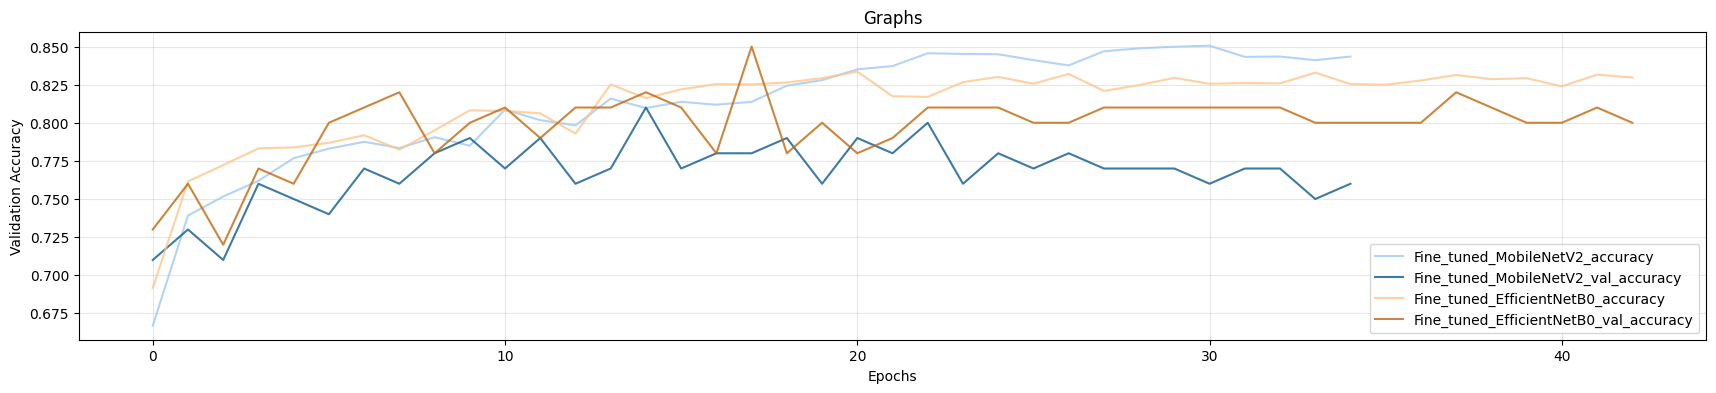

In [32]:
plot_accuracy(history_dict)

####15-2 Bar Graph

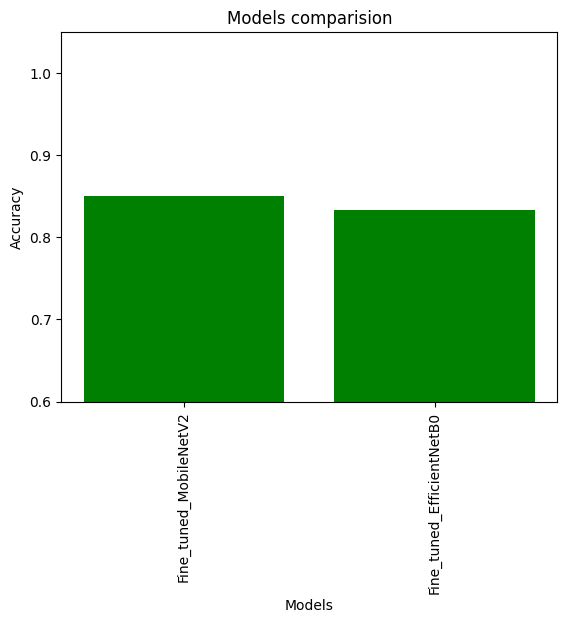

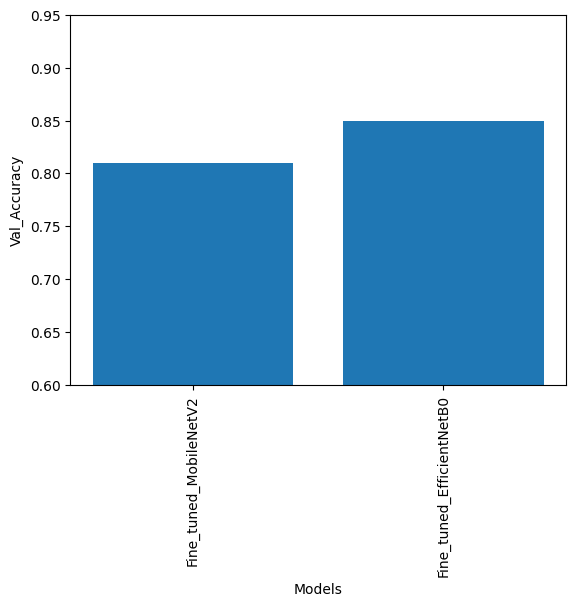

In [34]:
max_val_accuracy = {}
max_accuracy = {}
for model in history_dict.keys():
  max = np.max(history_dict[model]['val_accuracy'])
  max_val_accuracy[model] = max

  max = np.max(history_dict[model]['accuracy'])
  max_accuracy[model] = max

plt.bar(x=max_accuracy.keys(), height=max_accuracy.values(),color='green')
plt.ylim(0.6,1.05)
plt.xticks(rotation=90)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title('Models comparision')
plt.show()

plt.bar(x=max_val_accuracy.keys(), height=max_val_accuracy.values())
plt.ylim(0.6,.95)
plt.xticks(rotation=90)
plt.xlabel("Models")
plt.ylabel("Val_Accuracy")
plt.show()